In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.0 MB/s eta 

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



-

hub://activeloop/nih-chest-xray-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



-

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
class_names = train_ds.findings.info.class_names
num_classes = len(class_names)

class_count_raw = np.bincount(np.concatenate(train_ds.findings.numpy(aslist = True), axis=0))

for i, class_name in enumerate(class_names):
    print(f"{i+1}. {class_name}: {class_count_raw[i]}")

1. No Finding: 50500
2. Hernia: 141
3. Emphysema: 1423
4. Nodule: 4708
5. Pneumonia: 876
6. Consolidation: 2852
7. Cardiomegaly: 1707
8. Effusion: 8659
9. Mass: 4034
10. Pleural_Thickening: 2242
11. Atelectasis: 8280
12. Pneumothorax: 2637
13. Fibrosis: 1251
14. Infiltration: 13782
15. Edema: 1378


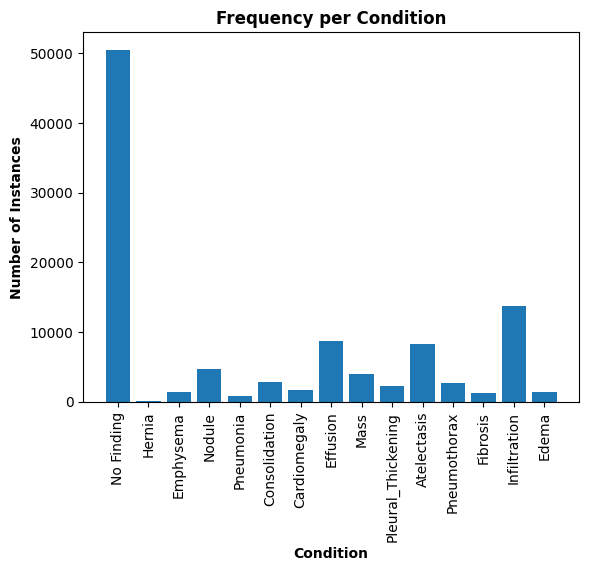

In [ ]:
plt.bar(np.arange(num_classes), class_count_raw, tick_label = class_names)
plt.xlabel('Condition', weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Instances', weight='bold')
plt.title('Frequency per Condition', weight='bold')
plt.show()

In [ ]:
train_ds_balanced = train_ds.query("select * sample by max_weight(contains(findings, 'Hernia'): 20, contains(findings, 'Pneumonia'): 8, contains(findings, 'Fibrosis'): 5, contains(findings, 'Edema'): 5, contains(findings, 'Emphysema'): 2, True: 1)")

In [ ]:
class_names = train_ds_balanced.findings.info.class_names
num_classes = len(class_names)

class_count_balanced = np.bincount(np.concatenate(train_ds_balanced.findings.numpy(aslist = True), axis=0))

for i, class_name in enumerate(class_names):
    print(f"{i+1}. {class_name}: {class_count_balanced[i]}")

1. No Finding: 41386
2. Hernia: 2125
3. Emphysema: 2511
4. Nodule: 4652
5. Pneumonia: 5665
6. Consolidation: 3100
7. Cardiomegaly: 1808
8. Effusion: 9728
9. Mass: 4203
10. Pleural_Thickening: 2562
11. Atelectasis: 9396
12. Pneumothorax: 2573
13. Fibrosis: 5124
14. Infiltration: 15844
15. Edema: 6032


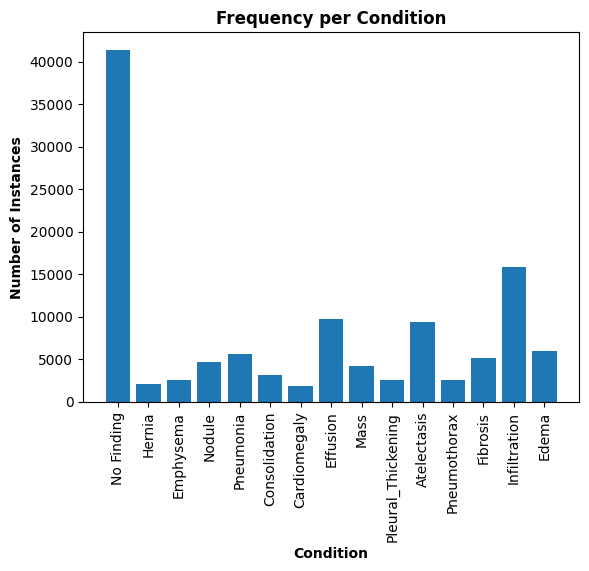

In [ ]:
plt.bar(np.arange(num_classes), class_count_balanced, tick_label = class_names)
plt.xlabel('Condition', weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Instances', weight='bold')
plt.title('Frequency per Condition', weight='bold')
plt.show()

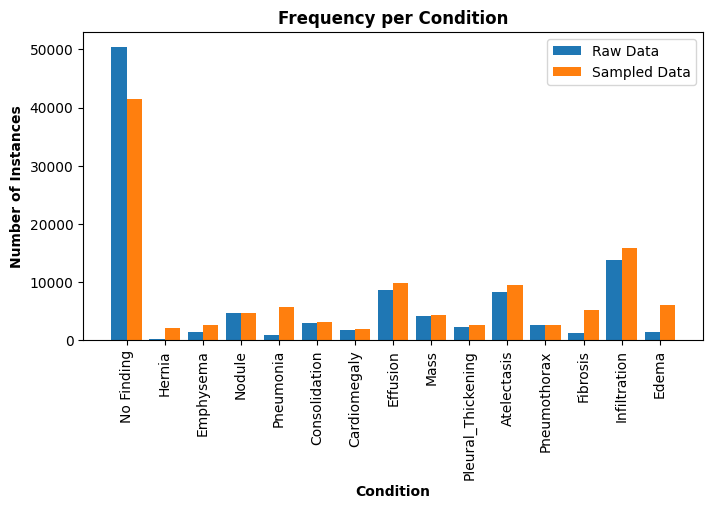

In [ ]:
X_axis = np.arange(len(class_names))

plt.figure(figsize=(8, 4))

plt.bar(X_axis - 0.2, class_count_raw, 0.4, label = 'Raw Data')
plt.bar(X_axis + 0.2, class_count_balanced, 0.4, label = 'Sampled Data')

plt.xticks(X_axis, class_names)
plt.xlabel('Condition', weight='bold')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Instances', weight='bold')
plt.title('Frequency per Condition', weight='bold')
plt.legend()
plt.show()